In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

# Load the dataset
data = pd.read_csv('GlobalWeatherRepository.csv')

# Handle missing values
# Fill missing values with the median for numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# Fill missing values with the most frequent value for categorical columns
categorical_columns = data.select_dtypes(exclude=[np.number]).columns
for column in categorical_columns:
    if not data[column].mode().empty:  # Ensure mode exists before filling
        data[column] = data[column].fillna(data[column].mode()[0])

# Remove rows with missing critical values
data.dropna(subset=['country', 'location_name'], inplace=True)

# Detect and remove outliers using z-score
numerical_columns_for_outliers = ['temperature_celsius', 'wind_mph', 'pressure_mb', 'precip_mm', 'humidity']
data = data.dropna(subset=numerical_columns_for_outliers)  # Ensure no NaNs before applying z-score
z_scores = np.abs(zscore(data[numerical_columns_for_outliers]))
data_cleaned = data[(z_scores < 3).all(axis=1)]

# Normalize numerical columns
scaler = MinMaxScaler()
data_cleaned[numerical_columns_for_outliers] = scaler.fit_transform(data_cleaned[numerical_columns_for_outliers])

# Convert 'last_updated' to datetime
data_cleaned['last_updated'] = pd.to_datetime(data_cleaned['last_updated'], errors='coerce')
data_cleaned.dropna(subset=['last_updated'], inplace=True)  # Drop rows with invalid dates

# Drop unnecessary columns
drop_cols = ['sunrise', 'sunset', 'moonrise', 'moonset']
data_cleaned.drop(columns=[col for col in drop_cols if col in data_cleaned.columns], inplace=True)

# Preview the cleaned data
print(data_cleaned.head())

# Check for remaining missing values
print("Missing values after preprocessing:\n", data_cleaned.isnull().sum())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch        last_updated  temperature_celsius  \
0        1.715849e+09 2024-05-16 13:15:00             0.515294   
1        1.715849e+09 2024-05-16 10:45:00             0.336471   
2        1.715849e+09 2024-05-16 09:45:00             0.430588   
3        1.715849e+09 2024-05-16 10:45:00             0.037647   
4        1.715849e+09 2024-05-16 09:45:00             0.501176   

   temperature_fahrenheit condition_text  ...  air_quality_Carbon_Monoxide  \
0                    79.8  Partly Cloudy  ...                        277.0   
1       

<ipython-input-3-45b0aa9eb033>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[numerical_columns_for_outliers] = scaler.fit_transform(data_cleaned[numerical_columns_for_outliers])
<ipython-input-3-45b0aa9eb033>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['last_updated'] = pd.to_datetime(data_cleaned['last_updated'], errors='coerce')
<ipython-input-3-45b0aa9eb033>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

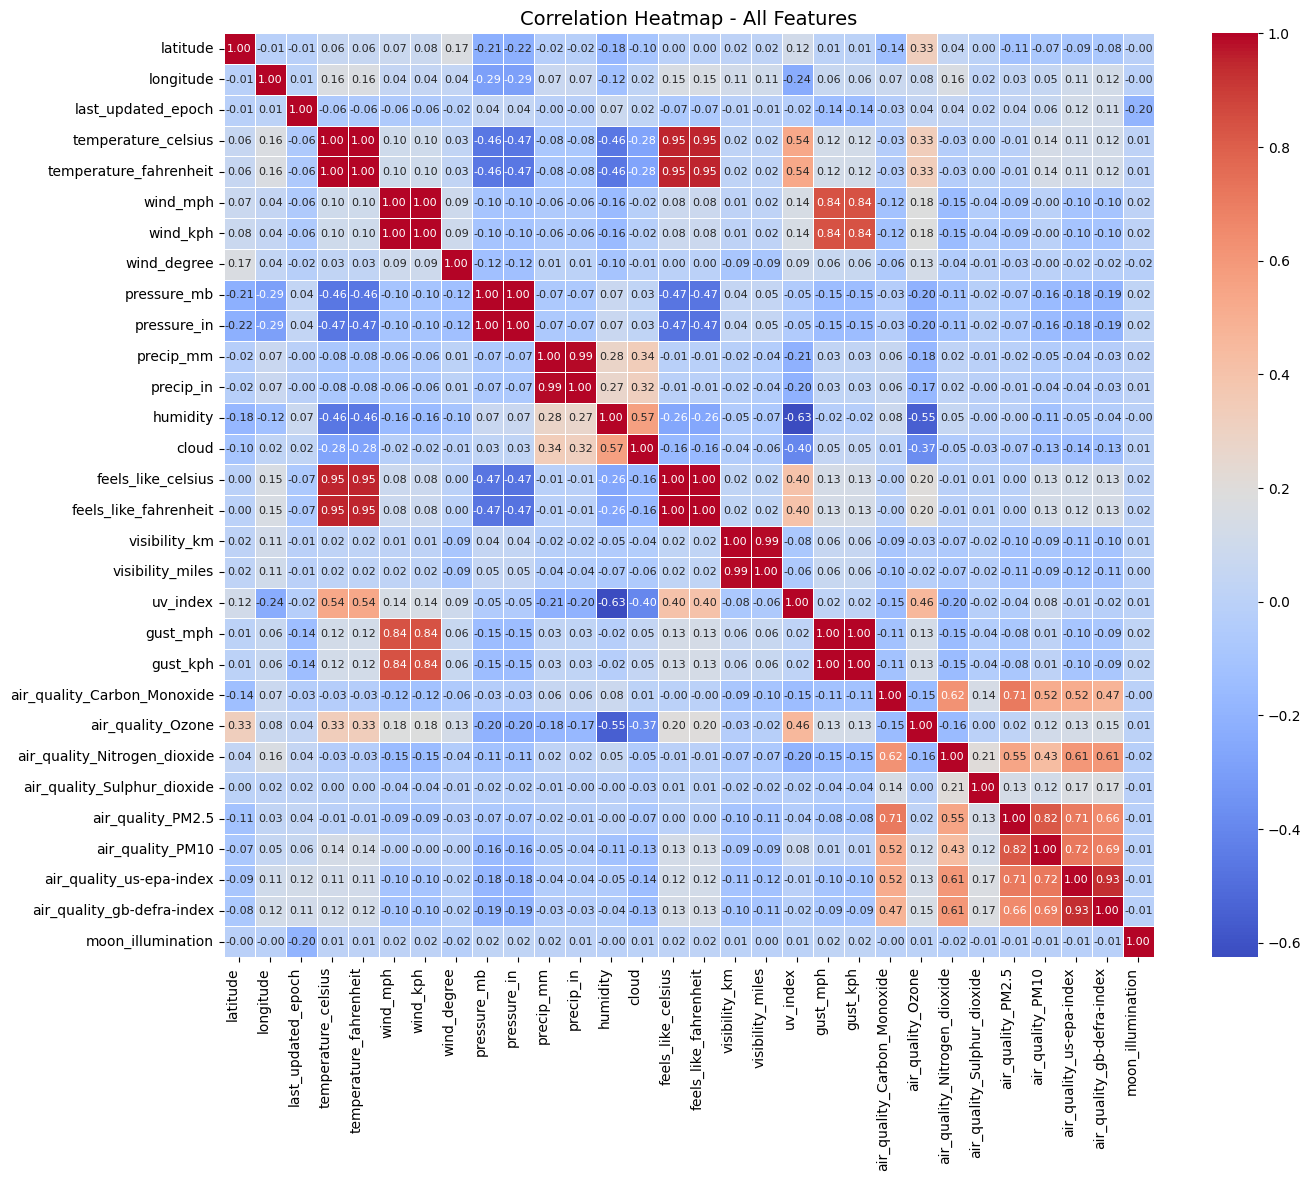

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns
numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix
corr_matrix = data_cleaned[numerical_columns].corr()

# Dynamically adjust figure size based on the number of columns
num_features = len(numerical_columns)
plt.figure(figsize=(num_features * 0.5, num_features * 0.4))  # Adjust width and height dynamically

# Create heatmap with adjustments
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})

# Improve readability
plt.xticks(rotation=90, ha='right')  # Rotate column labels
plt.yticks(rotation=0)  # Keep row labels readable
plt.title('Correlation Heatmap - All Features', fontsize=14)

# Save the heatmap
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


<ipython-input-8-75300a058649>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['last_updated'] = pd.to_datetime(data_cleaned['last_updated'])


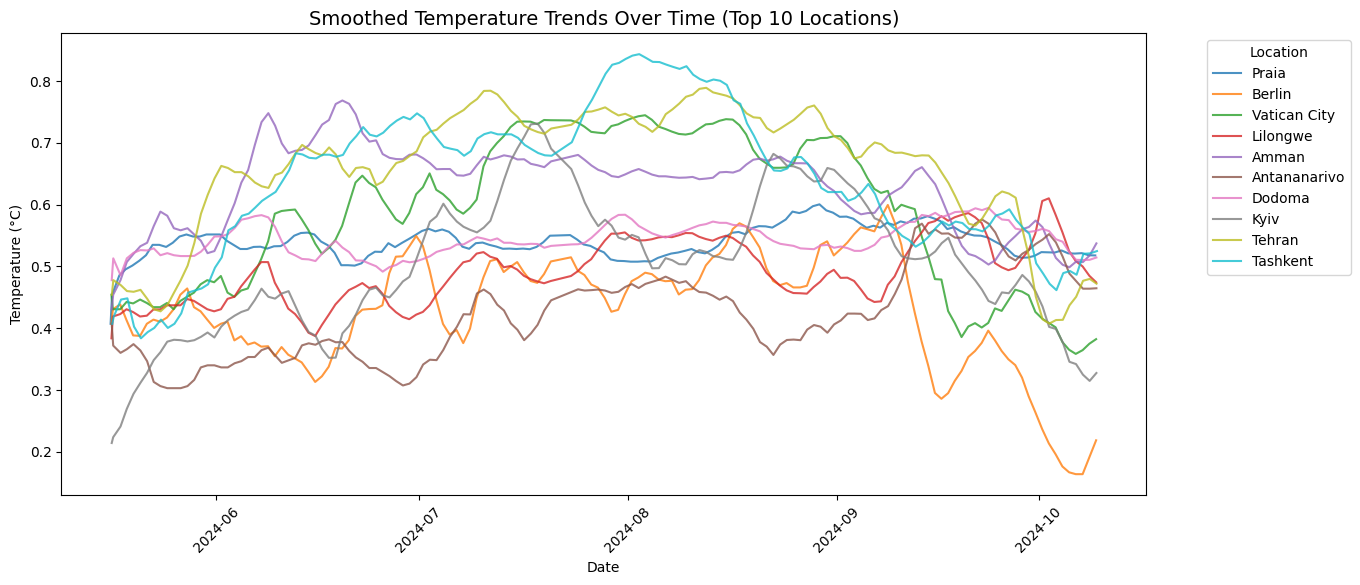

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'last_updated' is in datetime format
data_cleaned['last_updated'] = pd.to_datetime(data_cleaned['last_updated'])

# Reduce congestion by selecting only the top 10 locations with the most data points
top_locations = data_cleaned['location_name'].value_counts().head(10).index
filtered_data = data_cleaned[data_cleaned['location_name'].isin(top_locations)]

# Apply a rolling average to smooth temperature variations
filtered_data = filtered_data.sort_values(by='last_updated')  # Ensure proper time order
filtered_data['temperature_celsius_smoothed'] = filtered_data.groupby('location_name')['temperature_celsius'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Plot temperature trends for selected locations
plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered_data, x='last_updated', y='temperature_celsius_smoothed', hue='location_name', alpha=0.8)

# Improve readability
plt.title('Smoothed Temperature Trends Over Time (Top 10 Locations)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

# Save the plot
plt.savefig("temperature_trends.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


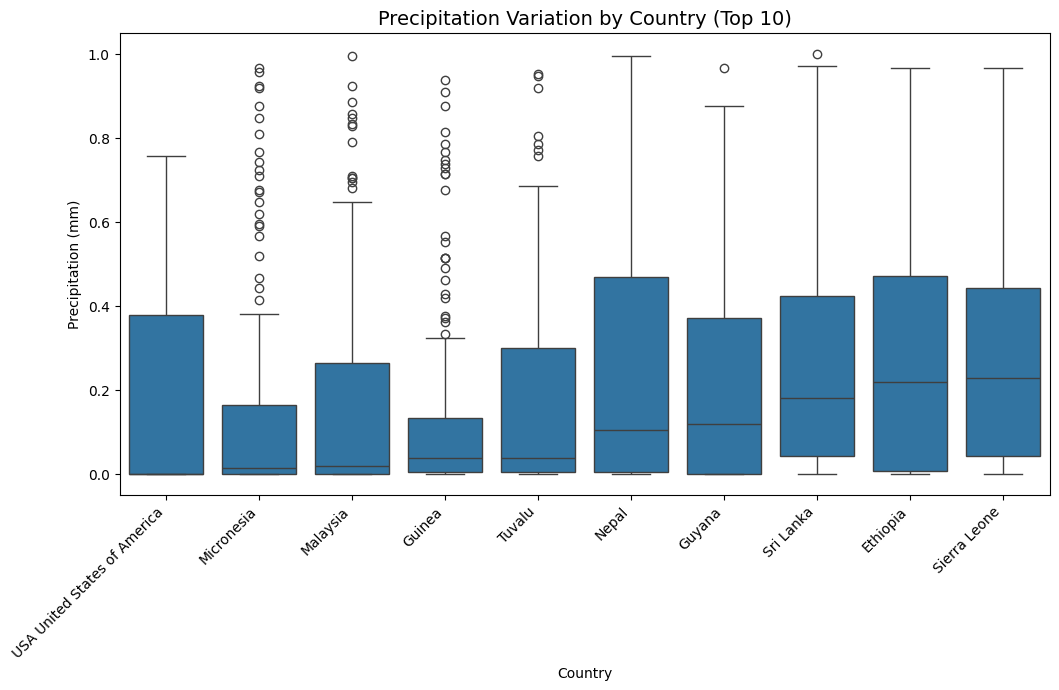

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'country' column is available
if 'country' in data_cleaned.columns and 'precip_mm' in data_cleaned.columns:
    # Select the top 10 countries with the highest precipitation variation
    top_countries = data_cleaned.groupby('country')['precip_mm'].std().nlargest(10).index
    filtered_data = data_cleaned[data_cleaned['country'].isin(top_countries)]

    # Sort countries by median precipitation for better visualization
    sorted_countries = filtered_data.groupby('country')['precip_mm'].median().sort_values().index

    # Set figure size and plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_data, x='country', y='precip_mm', order=sorted_countries)

    # Improve readability
    plt.title('Precipitation Variation by Country (Top 10)', fontsize=14)
    plt.xlabel('Country')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(rotation=45, ha='right')  # Tilt labels for better readability

    # Save the plot
    plt.savefig("precipitation_boxplot.png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

else:
    print("Warning: Necessary columns missing for precipitation visualization.")


Unique countries in the dataset: ['afghanistan' 'albania' 'algeria' 'andorra' 'angola'
 'antigua and barbuda' 'argentina' 'armenia' 'australia' 'austria'
 'azerbaijan' 'bahamas' 'bahrain' 'bangladesh' 'barbados' 'belarus'
 'belgium' 'belize' 'benin' 'bhutan' 'bolivia' 'bosnia and herzegovina'
 'botswana' 'brazil' 'brunei darussalam' 'bulgaria' 'burkina faso'
 'burundi' 'madagascar' 'cape verde' 'cambodia' 'cameroon' 'canada'
 'central african republic' 'chad' 'chile' 'china' 'comoros' 'congo'
 'costa rica' 'croatia' 'cuba' 'cyprus' 'czech republic'
 'democratic republic of congo' 'denmark' 'djibouti' 'dominica'
 'dominican republic' 'ecuador' 'egypt' 'el salvador' 'equatorial guinea'
 'eritrea' 'estonia' 'swaziland' 'ethiopia' 'fiji islands' 'finland'
 'france' 'gabon' 'gambia' 'georgia' 'germany' 'ghana' 'greece' 'grenada'
 'guatemala' 'guinea' 'guinea-bissau' 'guyana' 'haiti' 'vatican city'
 'honduras' 'hungary' 'iceland' 'india' 'indonesia' 'iran' 'iraq'
 'ireland' 'israel' 'italy' 

<ipython-input-6-962243a5837a>:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_country_resampled.fillna(method='ffill', inplace=True)
<ipython-input-6-962243a5837a>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_country_resampled['temperature_celsius'].fillna(method='ffill', inplace=True)
<ipython-input-6-962243a5837a>:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj

ARIMA MAE: 0.02540323479663649, RMSE: 0.03361468860012941


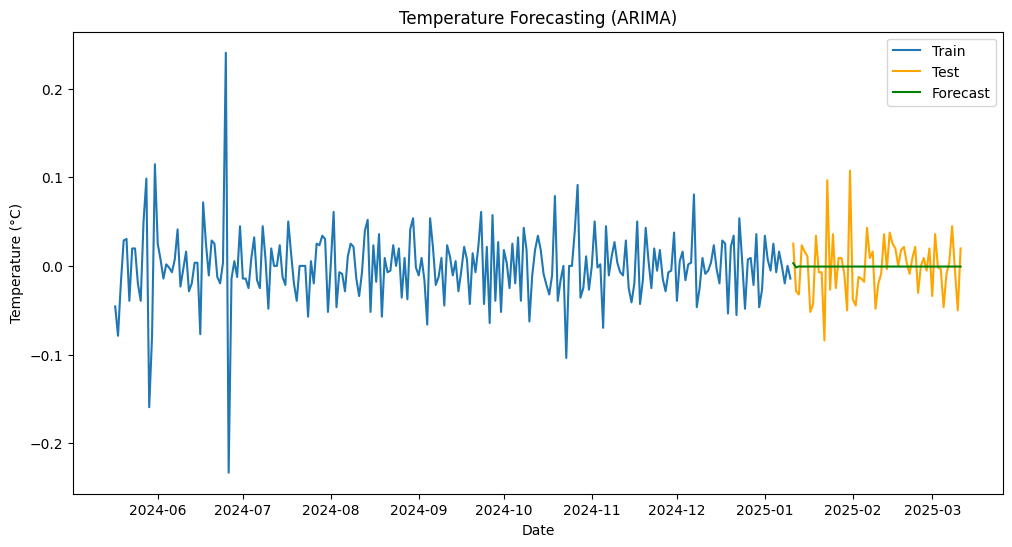

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Ensure 'country' column exists before filtering
if 'country' not in data_cleaned.columns:
    raise ValueError("The dataset does not contain a 'country' column.")

# Check unique country names
print("Unique countries in the dataset:", data_cleaned['country'].unique())

# Standardize country names
data_cleaned = data_cleaned.copy()  # Avoid SettingWithCopyWarning
data_cleaned['country'] = data_cleaned['country'].astype(str).str.strip().str.lower()

# Handle alternative names for the United States
usa_variants = ['united states', 'united states of america', 'usa', 'usa united states of america']
data_country = data_cleaned[data_cleaned['country'].isin(usa_variants)].copy()

if data_country.empty:
    raise ValueError("No data found for the United States. Check the country names in the dataset.")

print(f"Data for the United States contains {len(data_country)} rows.")

# Ensure 'last_updated' exists and is in datetime format
if 'last_updated' not in data_country.columns:
    raise ValueError("The dataset does not contain a 'last_updated' column.")

data_country['last_updated'] = pd.to_datetime(data_country['last_updated'], errors='coerce')
data_country.dropna(subset=['last_updated'], inplace=True)
data_country.set_index('last_updated', inplace=True)

# Remove any non-numeric columns before resampling
numeric_cols = data_country.select_dtypes(include=[np.number]).columns
data_country = data_country[numeric_cols]

# Resample to daily frequency
data_country_resampled = data_country.resample('D').mean()

if data_country_resampled.empty:
    raise ValueError("No data available after resampling. Check the frequency and dataset.")

print(f"Data after resampling contains {len(data_country_resampled)} rows.")

# Forward fill missing values
data_country_resampled.fillna(method='ffill', inplace=True)

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] <= 0.05  # p-value check

# Apply differencing if data is non-stationary
if not check_stationarity(data_country_resampled['temperature_celsius']):
    print("Data is not stationary. Applying differencing.")
    data_country_resampled['temperature_celsius'] = data_country_resampled['temperature_celsius'].diff().dropna()
    data_country_resampled['temperature_celsius'].fillna(method='ffill', inplace=True)

# Train-test split
train_size = int(len(data_country_resampled) * 0.8)
train, test = data_country_resampled[:train_size], data_country_resampled[train_size:]

# Fit ARIMA model
try:
    model = ARIMA(train['temperature_celsius'], order=(1, 1, 1))  # Adjust order if needed
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))

    # Evaluate model performance
    mae = mean_absolute_error(test['temperature_celsius'], forecast)
    rmse = np.sqrt(mean_squared_error(test['temperature_celsius'], forecast))
    print(f'ARIMA MAE: {mae}, RMSE: {rmse}')

    # Plot ARIMA forecast
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['temperature_celsius'], label='Train')
    plt.plot(test.index, test['temperature_celsius'], label='Test', color='orange')
    plt.plot(test.index, forecast, label='Forecast', color='green')
    plt.title('Temperature Forecasting (ARIMA)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")

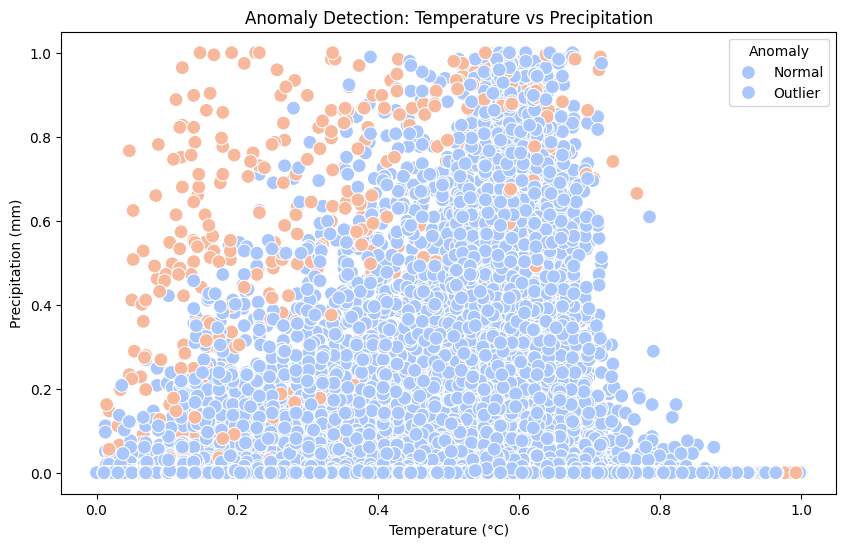

In [8]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Using numerical features for anomaly detection
features = ['temperature_celsius', 'wind_mph', 'pressure_mb', 'precip_mm', 'humidity']

# Ensure all required features exist in the dataset
missing_features = [col for col in features if col not in data_cleaned.columns]
if missing_features:
    raise ValueError(f"Missing required features for anomaly detection: {missing_features}")

# Drop rows with NaN values in selected features
data_cleaned = data_cleaned.dropna(subset=features)

# Train Isolation Forest to detect outliers
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Set random state for reproducibility
outliers = iso_forest.fit_predict(data_cleaned[features])

# Mark anomalies as -1 (outliers) and normal points as 1
data_cleaned['anomaly'] = np.where(outliers == -1, 1, 0)

# Visualize anomalies (e.g., temperature vs precipitation)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_cleaned, x='temperature_celsius', y='precip_mm', hue='anomaly', palette='coolwarm', s=100)
plt.title('Anomaly Detection: Temperature vs Precipitation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Anomaly', labels=['Normal', 'Outlier'])
plt.show()


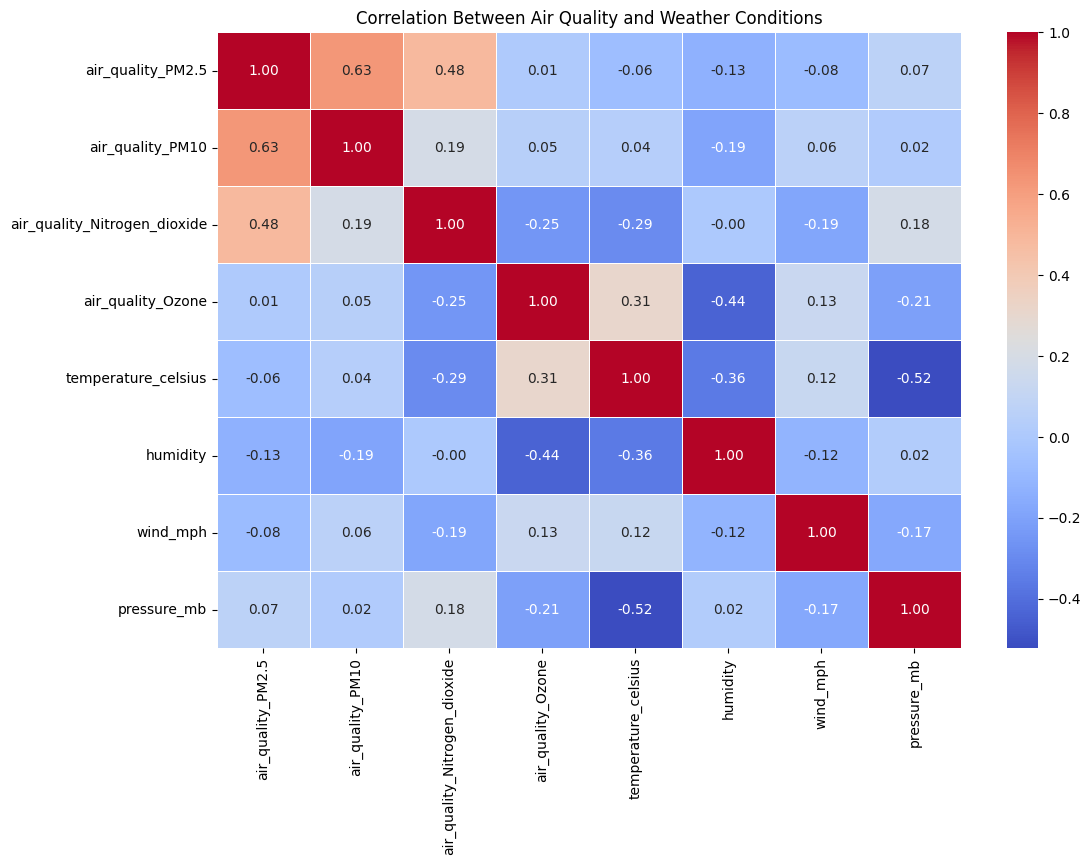

In [9]:
# Correlation analysis between weather and air quality
import matplotlib.pyplot as plt
import seaborn as sns

air_quality_columns = ['air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Nitrogen_dioxide', 'air_quality_Ozone']
weather_columns = ['temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb']

# Ensure all required columns exist in the dataset
missing_columns = [col for col in air_quality_columns + weather_columns if col not in data_cleaned.columns]
if missing_columns:
    raise ValueError(f"Missing required columns for correlation analysis: {missing_columns}")

# Drop rows with NaN values in selected columns
air_quality_data = data_cleaned[air_quality_columns + weather_columns].dropna()

# Compute correlation matrix
correlation_matrix = air_quality_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Air Quality and Weather Conditions')
plt.show()


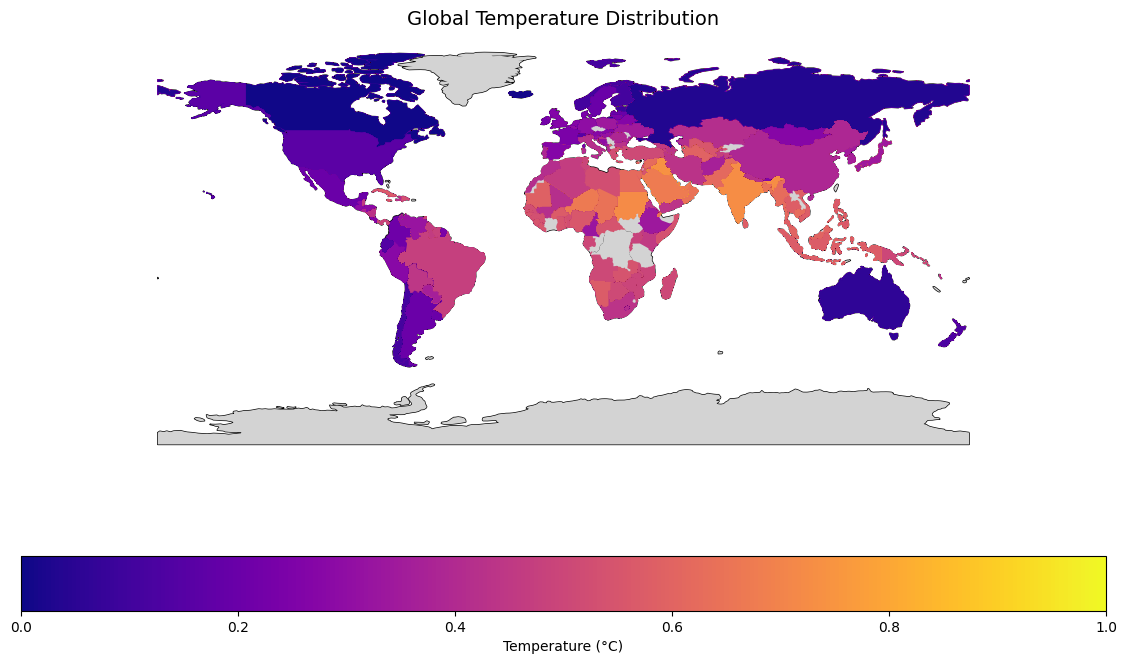

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Ensure required columns exist
if {'longitude', 'latitude', 'temperature_celsius', 'country'}.issubset(data_cleaned.columns):

    # Create a GeoDataFrame with geometry points
    geometry = [Point(xy) for xy in zip(data_cleaned['longitude'], data_cleaned['latitude'])]
    gdf = gpd.GeoDataFrame(data_cleaned, geometry=geometry)

    # Load the world map shapefile from local directory
    world = gpd.read_file("ne_110m_admin_0_countries.shp")  # Ensure correct path

    # Standardize country names for merging
    world['ADMIN'] = world['ADMIN'].str.lower()
    gdf['country'] = gdf['country'].str.lower()

    # Rename the 'geometry' column in the world dataframe to prevent conflicts
    world = world.rename(columns={'geometry': 'world_geometry'}).set_geometry('world_geometry')

    # Merge world map with weather data
    gdf_world = world.set_index('ADMIN').join(gdf.set_index('country'), how='left')

    # Set the geometry back for plotting
    gdf_world = gdf_world.set_geometry('world_geometry')

    # Plot temperature distribution with a custom color map
    fig, ax = plt.subplots(figsize=(14, 8))
    world.plot(ax=ax, linewidth=1, color="none", edgecolor="black")  # Draw country boundaries
    gdf_world.plot(column='temperature_celsius', ax=ax, cmap='plasma', legend=True,
                   legend_kwds={'label': "Temperature (°C)", 'orientation': "horizontal"},
                   missing_kwds={"color": "lightgrey", "label": "No Data"})  # Handle missing data

    # Improve readability
    plt.title('Global Temperature Distribution', fontsize=14)
    plt.axis("off")  # Hide axis labels

    # Save and show the plot
    plt.savefig("global_temperature_map.png", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Warning: Required columns missing for spatial analysis.")


In [24]:
!pip install prophet

In [25]:
import pandas as pd

# Load the dataset and check the first few rows
data_country = pd.read_csv('GlobalWeatherRepository.csv')  # Replace with your actual file path
print("First 20 rows of the dataset:")
print(data_country.head(20))  # Check the first 20 rows of the dataset

# Step 1: Check the unique values in 'last_updated' to understand its format
print("\nUnique values in 'last_updated' column:")
print(data_country['last_updated'].dropna().unique())

# Step 2: Strip whitespace in 'last_updated' and attempt datetime conversion again
data_country['last_updated'] = data_country['last_updated'].astype(str).str.strip()

# Step 3: Convert 'last_updated' to datetime and handle errors
data_country['last_updated'] = pd.to_datetime(data_country['last_updated'], errors='coerce', dayfirst=True)

# Step 4: Check for invalid dates
invalid_dates = data_country[data_country['last_updated'].isna()]
if not invalid_dates.empty:
    print("\nRows with invalid 'last_updated' values:")
    print(invalid_dates[['country', 'location_name', 'last_updated']])

# Step 5: Check if any rows are left after cleaning
missing_values = data_country.isna().sum()
if missing_values.sum() > 0:
    print("\nMissing values after cleaning:")
    print(missing_values)
else:
    print("\nNo missing values remaining.")

# Step 6: Prepare data for Prophet if valid dates exist
if data_country['last_updated'].notna().any():
    prophet_data = data_country[['last_updated', 'temperature_celsius']].dropna(subset=['last_updated', 'temperature_celsius']).reset_index(drop=True)

    # Rename columns to Prophet requirements
    prophet_data = prophet_data.rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})

    print("\nCleaned data for Prophet:")
    print(prophet_data.head())
else:
    print("No valid 'last_updated' values found after cleaning.")


First 20 rows of the dataset:
                country     location_name  latitude  longitude  \
0           Afghanistan             Kabul     34.52      69.18   
1               Albania            Tirana     41.33      19.82   
2               Algeria           Algiers     36.76       3.05   
3               Andorra  Andorra La Vella     42.50       1.52   
4                Angola            Luanda     -8.84      13.23   
5   Antigua and Barbuda      Saint John's     17.12     -61.85   
6             Argentina      Buenos Aires    -34.59     -58.67   
7               Armenia           Yerevan     40.18      44.51   
8             Australia          Canberra    -35.28     149.22   
9               Austria            Vienna     48.20      16.37   
10           Azerbaijan              Baku     40.40      49.88   
11              Bahamas            Nassau     25.08     -77.35   
12              Bahrain            Manama     26.24      50.58   
13           Bangladesh             Dhaka     

<ipython-input-25-2f508abe9b06>:16: UserWarning: Parsing dates in %Y-%m-%d %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data_country['last_updated'] = pd.to_datetime(data_country['last_updated'], errors='coerce', dayfirst=True)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qdwz1o0/8q5j62np.json


First 20 rows of the dataset:
                country     location_name  latitude  longitude  \
0           Afghanistan             Kabul     34.52      69.18   
1               Albania            Tirana     41.33      19.82   
2               Algeria           Algiers     36.76       3.05   
3               Andorra  Andorra La Vella     42.50       1.52   
4                Angola            Luanda     -8.84      13.23   
5   Antigua and Barbuda      Saint John's     17.12     -61.85   
6             Argentina      Buenos Aires    -34.59     -58.67   
7               Armenia           Yerevan     40.18      44.51   
8             Australia          Canberra    -35.28     149.22   
9               Austria            Vienna     48.20      16.37   
10           Azerbaijan              Baku     40.40      49.88   
11              Bahamas            Nassau     25.08     -77.35   
12              Bahrain            Manama     26.24      50.58   
13           Bangladesh             Dhaka     

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qdwz1o0/4gr81x9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35589', 'data', 'file=/tmp/tmp2qdwz1o0/8q5j62np.json', 'init=/tmp/tmp2qdwz1o0/4gr81x9n.json', 'output', 'file=/tmp/tmp2qdwz1o0/prophet_model6nl47kq4/prophet_model-20250312062259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-31-2b130dd17e42>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

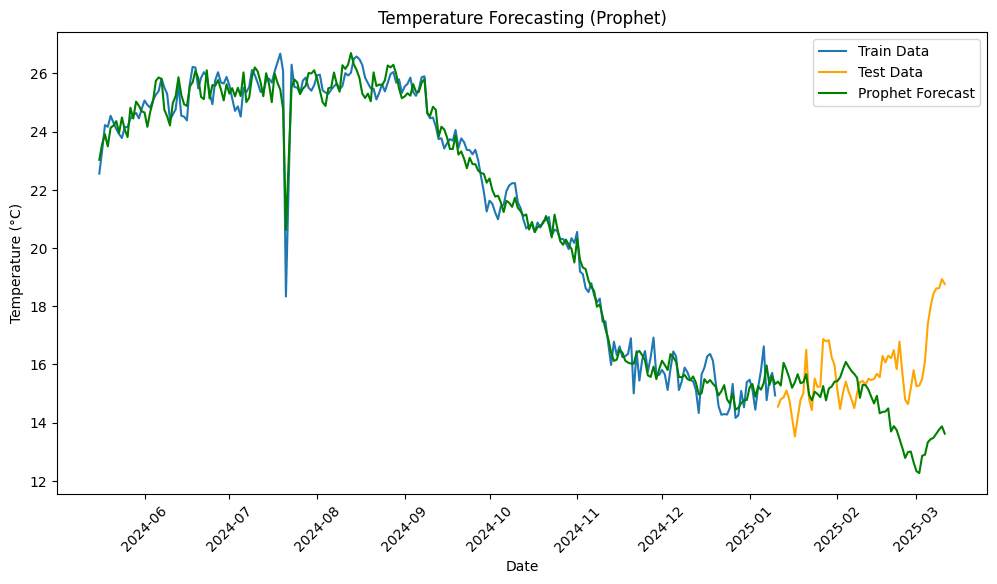

Prophet Model MAE: 1.7066086222172874
Prophet Model RMSE: 2.2210157413813776


In [31]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the dataset
data_country = pd.read_csv('GlobalWeatherRepository.csv')  # Replace with actual file path
print("First 20 rows of the dataset:")
print(data_country.head(20))

# Step 1: Convert 'last_updated' to datetime, handling errors
data_country['last_updated'] = pd.to_datetime(
    data_country['last_updated'].astype(str).str.strip(), errors='coerce')

# Step 2: Remove rows where 'last_updated' is NaT
data_country = data_country.dropna(subset=['last_updated'])

# Step 3: Check and report missing values
missing_values = data_country.isna().sum()
if missing_values.sum() > 0:
    print("\nMissing values after cleaning:")
    print(missing_values)
else:
    print("\nNo missing values remaining.")

# Step 4: Prepare data for Prophet
prophet_data = data_country[['last_updated', 'temperature_celsius', 'humidity', 'wind_mph', 'pressure_mb', 'air_quality_PM2.5', 'air_quality_PM10', 'cloud']].dropna().reset_index(drop=True)
prophet_data = prophet_data.rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
print("\nCleaned data for Prophet:")
print(prophet_data.head())

# Step 5: Apply log transformation to temperature only for positive values
prophet_data = prophet_data[prophet_data['y'] > 0]  # Remove zero or negative values to avoid log issues
prophet_data['y'] = np.log1p(prophet_data['y'])

# Step 6: Resample data to daily frequency
daily_mean = prophet_data.set_index('ds').resample('D').mean().reset_index()
prophet_data = daily_mean.dropna()

# Step 7: Split the data into train and test sets
train_size = int(len(prophet_data) * 0.8)
train_prophet, test_prophet = prophet_data[:train_size], prophet_data[train_size:]

print(f"\nTrain data shape: {train_prophet.shape}")
print(f"Test data shape: {test_prophet.shape}")

# Step 8: Build and fit Prophet model with additional regressors
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_seasonality(name='yearly', period=365, fourier_order=15)
prophet_model.add_regressor('humidity')
prophet_model.add_regressor('wind_mph')
prophet_model.add_regressor('pressure_mb')
prophet_model.add_regressor('air_quality_PM2.5')
prophet_model.add_regressor('air_quality_PM10')
prophet_model.add_regressor('cloud')
prophet_model.fit(train_prophet)

# Step 9: Make predictions
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
future = future.merge(prophet_data[['ds', 'humidity', 'wind_mph', 'pressure_mb', 'air_quality_PM2.5', 'air_quality_PM10', 'cloud']], on='ds', how='left')
forecast_prophet = prophet_model.predict(future)

# Step 10: Inverse log transformation to get actual temperature values
forecast_prophet['yhat'] = np.expm1(forecast_prophet['yhat'])
test_prophet['y'] = np.expm1(test_prophet['y'])

# Step 11: Plot Prophet Forecast
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], np.expm1(train_prophet['y']), label='Train Data')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Data', color='orange')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green')
plt.title('Temperature Forecasting (Prophet)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Step 12: Evaluate the Prophet Model
forecast_test = forecast_prophet.set_index('ds').loc[test_prophet.set_index('ds').index]
mae_prophet = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))
print(f'Prophet Model MAE: {mae_prophet}')
print(f'Prophet Model RMSE: {rmse_prophet}')

[5%] Data loaded and cleaned...
[10%] Feature scaling completed...
[20%] Train-test split completed...
[30%] Random Forest model initialized...
[50%] Random Forest training completed...
[70%] Cross-validation completed...
[80%] Predictions completed...
[90%] Model evaluation completed...


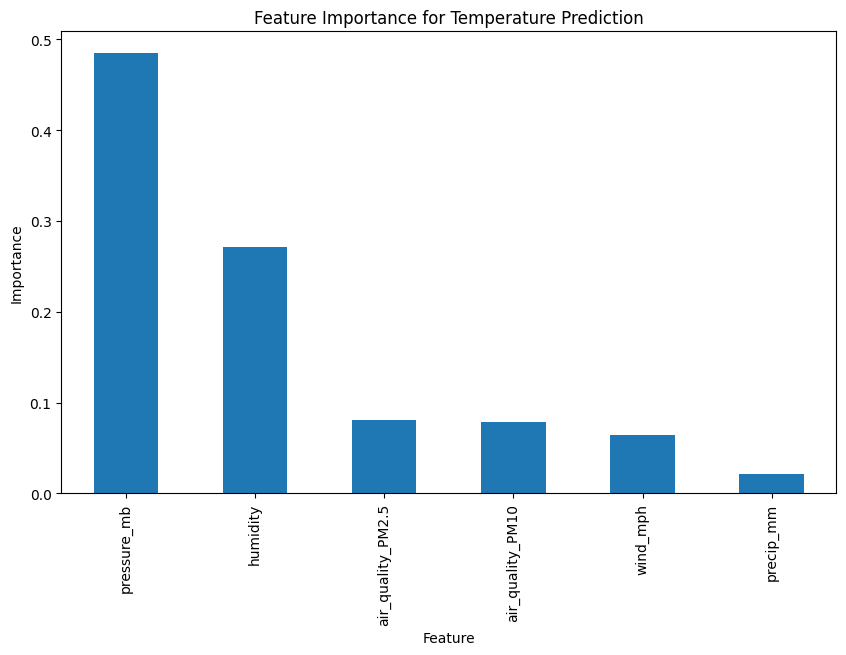

[100%] Feature importance visualization completed!
Random Forest MAE: 3.9811290139699365
Random Forest RMSE: 5.755144430133159
Random Forest R²: 0.6393051307477429
Cross-Validated MAE (5-Fold): 4.468245665109626


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Load and clean dataset
data = pd.read_csv('GlobalWeatherRepository.csv')  # Adjust the path as needed
data_cleaned = data.dropna()
print("[5%] Data loaded and cleaned...")

# Prepare the data for feature importance
features = ['humidity', 'wind_mph', 'pressure_mb', 'precip_mm', 'air_quality_PM2.5', 'air_quality_PM10']
target = 'temperature_celsius'

# Ensure required columns exist
data_cleaned = data_cleaned[features + [target]].dropna()

# Split data into features (X) and target (y)
X = data_cleaned[features]
y = data_cleaned[target]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("[10%] Feature scaling completed...")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("[20%] Train-test split completed...")

# Build optimized Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster computation
)
print("[30%] Random Forest model initialized...")
rf_model.fit(X_train, y_train)
print("[50%] Random Forest training completed...")

# Cross-validation for better evaluation
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
avg_cv_mae = -np.mean(cv_scores)
print("[70%] Cross-validation completed...")

# Predict temperature
y_pred = rf_model.predict(X_test)
print("[80%] Predictions completed...")

# Evaluate model performance
mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)
print("[90%] Model evaluation completed...")

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance for Temperature Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
print("[100%] Feature importance visualization completed!")

# Print model performance metrics
print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest R²: {r2_rf}')
print(f'Cross-Validated MAE (5-Fold): {avg_cv_mae}')

[===============================================   ] 95%

<Figure size 1000x600 with 0 Axes>

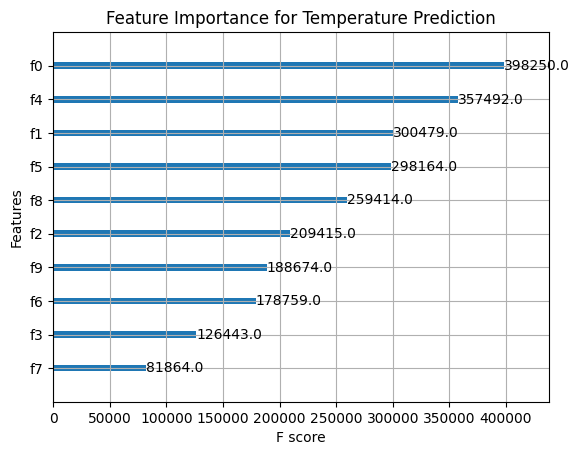

[==================================================] 100%
Completed!
XGBoost MAE: 2.4458248787499226
XGBoost RMSE: 3.752999193566854
XGBoost R²: 0.8489071649729851
Cross-Validated MAE (15-Fold): 2.4084667282711227


In [8]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

def update_progress(progress):
    sys.stdout.write("\r[{:<50}] {:.0f}%".format('=' * (progress // 2), progress))
    sys.stdout.flush()

# Load and clean dataset
update_progress(5)
data = pd.read_csv('GlobalWeatherRepository.csv')  # Adjust path as needed
data_cleaned = data.dropna()

# Prepare the data for feature importance
features = ['humidity', 'wind_mph', 'pressure_mb', 'precip_mm', 'air_quality_PM2.5', 'air_quality_PM10', 'uv_index', 'visibility_km', 'gust_mph', 'cloud']
target = 'temperature_celsius'

data_cleaned = data_cleaned[features + [target]].dropna()
update_progress(10)

# Increase dataset size for better generalization
data_sampled = data_cleaned.sample(frac=0.95, random_state=42)  # More data for better accuracy

# Split data into features (X) and target (y)
X = data_sampled[features]
y = data_sampled[target]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
update_progress(20)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.08, random_state=42)  # More training data
update_progress(30)

# Check for GPU availability and adjust settings
use_gpu = False
try:
    import xgboost as xgb
    use_gpu = xgb.config_context().is_cuda_support()
except:
    pass

tree_method = 'hist' if not use_gpu else 'gpu_hist'

def fit_xgboost():
    global xgb_model
    xgb_model = XGBRegressor(
        tree_method=tree_method,  # Auto-adjusted for GPU availability
        n_estimators=700,  # Increased estimators for better learning
        max_depth=18,  # Deeper trees for capturing complexity
        learning_rate=0.015,  # Lower learning rate for fine-tuned adjustments
        subsample=0.99,  # Near full dataset utilization
        colsample_bytree=0.99,  # More features per tree
        min_child_weight=1,  # Allowing more splits
        gamma=0.3,  # Higher regularization
        reg_lambda=3.0,  # Stronger L2 regularization
        reg_alpha=1.5,  # Stronger L1 regularization
        random_state=42,
        n_jobs=-1  # Utilize all CPU cores
    )
    update_progress(40)
    xgb_model.fit(X_train, y_train)
    update_progress(60)

fit_xgboost()

# Cross-validation for better evaluation
cv_scores = cross_val_score(xgb_model, X_scaled, y, cv=15, scoring='neg_mean_absolute_error')  # Increased to 15-Fold CV for better validation
avg_cv_mae = -np.mean(cv_scores)
update_progress(75)

# Predict temperature
y_pred = xgb_model.predict(X_test)
update_progress(85)

# Evaluate model performance
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_xgb = r2_score(y_test, y_pred)
update_progress(95)

# Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model)
plt.title('Feature Importance for Temperature Prediction')
plt.show()
update_progress(100)
print("\nCompleted!")

# Print model performance metrics
print(f'XGBoost MAE: {mae_xgb}')
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'XGBoost R²: {r2_xgb}')
print(f'Cross-Validated MAE (15-Fold): {avg_cv_mae}')

In [11]:
print("Available columns:", data_cleaned.columns)


Available columns: Index(['humidity', 'wind_mph', 'pressure_mb', 'precip_mm', 'air_quality_PM2.5',
       'air_quality_PM10', 'uv_index', 'visibility_km', 'gust_mph', 'cloud',
       'temperature_celsius'],
      dtype='object')


✅ 'last_updated' restored successfully!


<ipython-input-12-eacb3096697c>:27: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  monthly_avg_temp_rolling = monthly_avg_temp.rolling(window=3, axis=1, min_periods=1).mean()


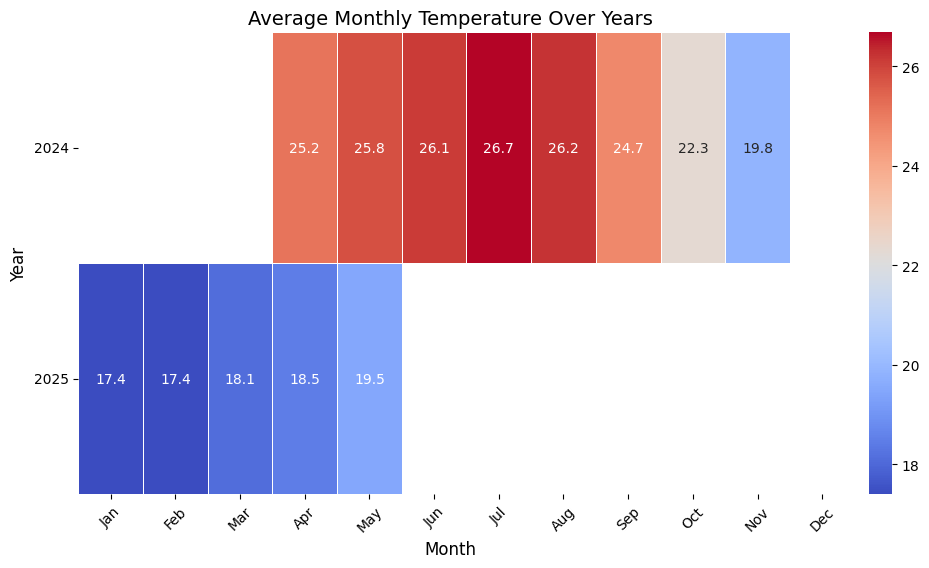

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Restore 'last_updated' if missing
data = pd.read_csv('GlobalWeatherRepository.csv')

if 'last_updated' not in data_cleaned.columns and 'last_updated' in data.columns:
    data_cleaned['last_updated'] = data['last_updated']
    print("✅ 'last_updated' restored successfully!")

# Convert 'last_updated' to datetime safely
data_cleaned['last_updated'] = pd.to_datetime(data_cleaned['last_updated'], errors='coerce')

# Extract year and month
data_cleaned['year'] = data_cleaned['last_updated'].dt.year
data_cleaned['month'] = data_cleaned['last_updated'].dt.month

# Remove NaT values (if any) after conversion
data_cleaned = data_cleaned.dropna(subset=['year', 'month', 'temperature_celsius'])

# ✅ Group by year and month for seasonal trend analysis
monthly_avg_temp = data_cleaned.groupby(['year', 'month'])['temperature_celsius'].mean().unstack()

# ✅ Apply a rolling average for smoother trends
monthly_avg_temp_rolling = monthly_avg_temp.rolling(window=3, axis=1, min_periods=1).mean()

# ✅ Plot a heatmap for better seasonal visualization
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_avg_temp_rolling, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5)

# ✅ Improve plot aesthetics
plt.title('Average Monthly Temperature Over Years', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.xticks(ticks=np.arange(12) + 0.5, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.yticks(rotation=0)
plt.show()
